In [1]:
import matplotlib.pyplot as plt
import numpy as np

cos = np.cos
sin = np.sin

In [2]:
import sim_trajec

2021-02-18 15:16:53,241 [INFO] Generating grammar tables from /usr/lib/python3.5/lib2to3/Grammar.txt
2021-02-18 15:16:53,265 [INFO] Generating grammar tables from /usr/lib/python3.5/lib2to3/PatternGrammar.txt
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future versio

In [3]:
import ukf_sqrt.ukf_sqrt as ukf_sqrt
import fly_plot_lib as fpl

2.2.2
recommended version: 1.1.1 or greater


In [120]:
turns = 34
df = sim_trajec.get_many_turns_dynamic_wind_three(turns=turns, Lsec=100)

# Plot the data

In [121]:
def plot_trajectory(df, ax=None):
    dt = np.median(np.diff(df['t']))

    v_x = df['v_para']*cos(df['phi']) - df['v_perp']*sin(df['phi'])
    v_y = df['v_para']*sin(df['phi']) + df['v_perp']*cos(df['phi'])

    x_pos = np.cumsum(v_x)*dt
    y_pos = np.cumsum(v_y)*dt

    df['v_x'] = v_x
    df['v_y'] = v_y

    df['x_pos'] = x_pos
    df['y_pos'] = y_pos
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    fpl.plot.colorline_with_heading(ax, df['x_pos'].values, df['y_pos'].values, df['t'].values, df['phi'].values, 
                                    nskip=10, size_radius=1, deg=False, colormap='viridis', center_point_size=0.1)

    ax.set_aspect('equal')
    
    return ax

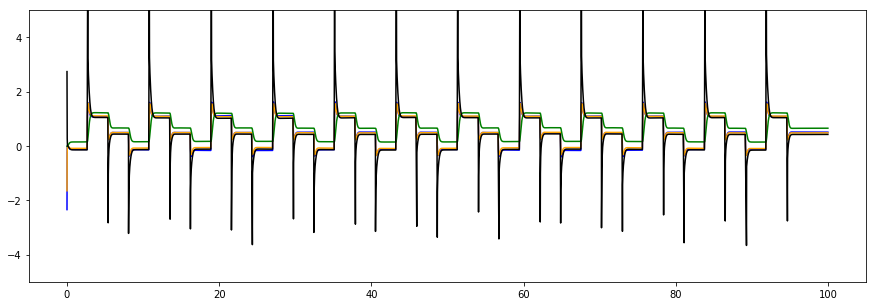

In [122]:
# plot time series
if 0:
    fig = plt.figure(figsize=(15,10))

    ax1 = fig.add_subplot(711)
    ax1.plot(df.t, df.v_para)
    ax1.set_ylabel('$v_{para}$')

    ax2 = fig.add_subplot(712)
    ax2.plot(df.t, df.v_perp)
    ax2.set_ylabel('$v_{perp}$')

    ax3 = fig.add_subplot(713)
    ax3.plot(df.t, df.a_para)
    ax3.set_ylabel('$a_{para}$')

    ax4 = fig.add_subplot(714)
    ax4.plot(df.t, df.a_perp)
    ax4.set_ylabel('$a_{perp}$')

    ax5 = fig.add_subplot(715)
    ax5.plot(df.t, df.phi)
    ax5.set_ylabel('$\phi$')

    ax6 = fig.add_subplot(716)
    ax6.plot(df.t, df.zeta)
    ax6.set_ylabel('$\zeta$')
    
if 1:
    # base line subtracted.. hoping to find scale calibration
    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(111)
    ax1.plot(df.t, df.v_perp/df.v_para - (df.v_perp/df.v_para).values[10], color='blue')
    ax1.plot(df.t, df.a_perp/df.a_para - (df.a_perp/df.a_para).values[10], color='orange')
    ax1.plot(df.t, df.phi - df.phi.values[10], color='green')
    
    ax1.plot(df.t, df.u_perp/df.u_para - (df.u_perp/df.u_para).values[10], color='black')

    plt.ylim(-5,5)

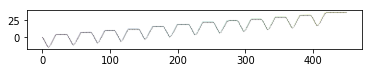

In [123]:
# plot trajectory
plot_trajectory(df)

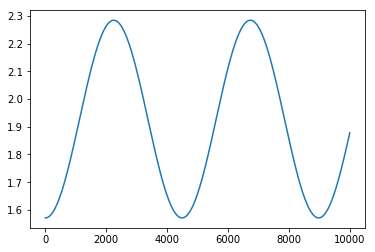

In [124]:
plt.plot(df.zeta)

# Run the UKF

In [125]:
km1 = df.km1.values[0]
km2 = df.km2.values[0]
km3 = df.km3.values[0]
km4 = df.km4.values[0]
ks1 = df.ks1.values[0]
ks2 = df.ks2.values[0]
ks3 = df.ks3.values[0]
ks4 = df.ks4.values[0]
ks5 = df.ks5.values[0]
C_para = df.C_para.values[0]
C_perp = df.C_perp.values[0]
C_phi = df.C_phi.values[0]
dt = np.median(np.diff(df.t.values))

In [126]:
def f(x, u, W=None):
    v_para, v_perp, phi, phidot, w, zeta = np.ravel(x[:,-1])
    
    u_para, u_perp, u_phi = np.ravel(u[:,-1])

    a_para = v_para - w*cos(phi-zeta)
    a_perp = v_perp + w*sin(phi-zeta)

    # constant wind
    zetadot = 0
    wdot = 0

    f0 = np.matrix([ v_perp*phidot - C_para*(v_para-w*cos(phi-zeta)),
                    -v_para*phidot - C_perp*(v_perp+w*sin(phi-zeta)),
                    phidot,
                    -C_phi*phidot,
                    wdot,
                    zetadot]).T

    f_para = np.matrix([km1, 0, 0, km2, 0, 0]).T*u_para
    f_perp = np.matrix([0, km3, 0, 0, 0, 0]).T*u_perp
    f_phi = np.matrix([0,0,0,km4,0,0]).T*u_phi

    xdot = f0 + f_para + f_perp + f_phi
    
    #print( (np.matrix(x[:,-1]).T + xdot*dt).T )
    
    return np.matrix(x[:,-1]).T + xdot*dt + W

In [127]:
def h_calibrated(x, u, W):
    v_para, v_perp, phi, phidot, w, zeta = np.ravel(x[:,-1])
    
    u_para, u_perp, u_phi = u
    
    a_para = v_para - w*cos(phi-zeta)
    a_perp = v_perp + w*sin(phi-zeta)
    
    s1 = a_perp/a_para #np.arctan2(a_perp, a_para)
    s2 = v_perp/v_para #np.arctan2(v_perp, v_para)
    
    y = np.matrix([phi*ks1, 
                   s1*ks2 + ks3, 
                   s2*ks4 + ks5]).T
    
    return y + W

In [128]:
if 0:
    x0 = np.matrix([df.v_para.values[0],
                    df.v_perp.values[0],
                    df.phi.values[0],
                    df.phidot.values[0],
                    df.w.values[0],
                    df.zeta.values[0],
                   ]).T
    x0 += 0
else:
    x0 = np.matrix([0.5]*6).T

In [129]:
u = np.matrix([df.u_para.values, 
               df.u_perp.values, 
               df.u_phi.values])

In [130]:
N = len(df)

In [131]:
Q = 1e-10*np.eye(len(x0))
R = 1e-7*np.eye(3)

# process covariance
# make it a 3D matrix in time
Qt = np.tile(np.expand_dims(Q, 2), N)

# measurement covariance
# make it a 3D matrix in time
Rt = np.tile(np.expand_dims(R, 2), N)

In [132]:
a_para = df.v_para - df.w*cos(df.phi-df.zeta)
a_perp = df.v_perp + df.w*sin(df.phi-df.zeta)

s1 = a_perp/a_para
s2 = df.v_perp/df.v_para
    
y = np.matrix([df.phi.values*df.ks1.values, 
               s1.values*df.ks2.values + df.ks3.values, 
               s2.values*df.ks4.values + df.ks5.values])

In [133]:
print(y.shape, x0.shape, Qt.shape, Rt.shape, u.shape)

(3, 10000) (6, 1) (6, 6, 10000) (3, 3, 10000) (3, 10000)


In [134]:
n = -1

In [135]:
Q.shape

(6, 6)

In [136]:
R.shape

(3, 3)

In [137]:
xhat, P, s = ukf_sqrt(y[:,0:n], x0, f, h_calibrated, Qt, Rt, u[:,0:n], P0=[10]*6, alpha=0.001, beta=2)

/home/caveman/BMD2/lib/python3.5/site-packages/pyUKFsqrt-0.0.1-py3.5.egg/ukf_sqrt/utils.py:66: RuntimeWarning: divide by zero encountered in true_divide
/home/caveman/BMD2/lib/python3.5/site-packages/pyUKFsqrt-0.0.1-py3.5.egg/ukf_sqrt/utils.py:67: RuntimeWarning: invalid value encountered in multiply
/home/caveman/BMD2/lib/python3.5/site-packages/pyUKFsqrt-0.0.1-py3.5.egg/ukf_sqrt/utils.py:63: RuntimeWarning: invalid value encountered in double_scalars
/home/caveman/BMD2/lib/python3.5/site-packages/pyUKFsqrt-0.0.1-py3.5.egg/ukf_sqrt/utils.py:64: RuntimeWarning: divide by zero encountered in double_scalars


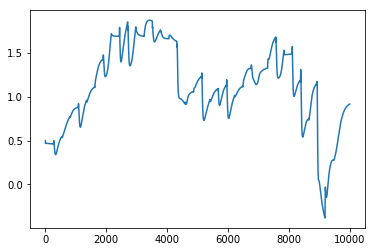

In [138]:
plt.plot(xhat[5,:].T)

In [139]:
import pynumdiff

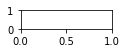

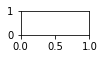

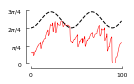

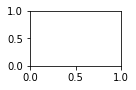

In [140]:
import figurefirst as fifi

layout = fifi.svg_to_axes.FigureLayout('ukf_plot_dynamic.svg', autogenlayers=True, make_mplfigures=True, hide_layers=[])

ax = layout.axes[('ukf_'+str(50), 'ukf')]

ax.plot(xhat[5,:].T, color='red', linewidth=0.5)
#ax.hlines(np.pi/2., 0, len(xhat.T), linestyles='--', color='black')
ax.plot(df.zeta, '--', color='black', linewidth=1)

# for the zoom

# fills

ax.set_xlim(0, 10000)
ax.set_ylim(0, 3.1*np.pi/4.)

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 spine_locations={'left': 5,
                                                  'bottom': 5},
                                 xticks=[0, 10000],
                                 yticks=[0, np.pi/4., 2*np.pi/4., 3*np.pi/4.],
                                 tick_length=2.5,
                                 linewidth=0.5)

ax.set_xlim(0, 10000)
ax.set_xticklabels([0, int(np.ceil(10000*dt))])
ax.set_ylim(0, 3.1*np.pi/4.)

ax.set_yticklabels(['$0$', '$\pi/4$', '$2\pi/4$', '$3\pi/4$'])

#ax.set_ylabel('Wind direction $(\zeta)$')
#ax.set_xlabel('Time steps')

fifi.mpl_functions.set_fontsize(ax, 6)

layout.append_figure_to_layer(layout.figures['ukf_'+str(50)], 'ukf_'+str(50), cleartarget=True)

layout.write_svg('ukf_plot_dynamic.svg')

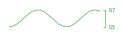

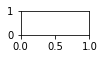

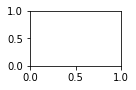

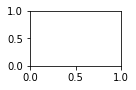

In [141]:
layout = fifi.svg_to_axes.FigureLayout('ukf_plot_dynamic.svg', autogenlayers=True, make_mplfigures=True, hide_layers=[])

ax = layout.axes[('wind', 'wind')]

ax.plot(df.w, color='forestgreen', linewidth=0.5)

ax.set_xlim(0, 10000)

fifi.mpl_functions.adjust_spines(ax, ['right'], 
                                 spine_locations={'right': 5,
                                                  'bottom': 5},
                                 xticks=[0, 10000],
                                 yticks=[0.5, 0.7],
                                 tick_length=2.5,
                                 linewidth=0.5,
                                 color='forestgreen')

ax.set_xlim(0, 10000)

ax.tick_params(axis='y', colors='forestgreen')


fifi.mpl_functions.set_fontsize(ax, 4.5)

layout.append_figure_to_layer(layout.figures['wind'], 'wind', cleartarget=True)

layout.write_svg('ukf_plot_dynamic.svg')



In [142]:
from IPython.display import display,SVG
display(SVG('ukf_plot_dynamic.svg'))